In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('../data/public/train.csv')
sub = pd.read_csv('../data/public/sample_submission.csv')

In [3]:
trn_img = os.listdir('../data/public/train/')
trn_img

['부산시', '광주광역시', '경기도', '대구광역시', '인천광역시', '서울시']

In [1]:
import sys
import importlib
from types import SimpleNamespace
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import softmax
from joblib import Parallel, delayed
# import seaborn as sns
import scipy as sp

import warnings
warnings.filterwarnings("ignore")

sys.path.append("/home/hhl/바탕화면/dacon/dacon21/model/using_cofing")
# sys.argv = ['--config', 'config1_try']
sys.argv = ['--config', 'config1']

from models import *
from loss import *
from run import *
from loader import *
from utils import *

Using config file config1


In [250]:
class config1_try:
    DEBUG=False
    num_workers=8
    gpus='0'
    distributed_backend=None
    sync_batchnorm=True
    gradient_accumulation_steps=4
    precision=16
    warmup_epo=1
    cosine_epo=19
    lr=0.002
    weight_decay=0.0001
    p_trainable=True
    crit='bce'
    backbone='tf_efficientnet_b3_ns'
    embedding_size=512
    pool='gem'
    arcface_s=45.0
    arcface_m=0.4
    neck='option-D'
    head='arc_margin'
    pretrained_weights=None
    optim='sgd'
    batch_size=12
    n_splits=5
    fold=0
    seed=1028
    device='cuda:0'
    out_dim=1049
    n_classes=1049
    class_weights='log'
    class_weights_norm='batch'
    normalization='imagenet'
    crop_size=448
    model='/home/hhl/바탕화면/dacon/dacon21/model/cofig1_try/tf_efficientnet_b3_ns_best_fold_0.pth'


config1_try_tr_aug = A.Compose([ 
    A.LongestMaxSize(664,p=1),
    A.PadIfNeeded(664, 664, border_mode=cv2.BORDER_CONSTANT,p=1),
    A.RandomCrop(always_apply=False, p=1.0, height=config1_try.crop_size, width=config1_try.crop_size), 
    A.HorizontalFlip(always_apply=False, p=0.5), 
],
p=1.0
)

config1_try_val_aug = A.Compose([ A.LongestMaxSize(664,p=1),
                             A.PadIfNeeded(664, 664, border_mode=cv2.BORDER_CONSTANT,p=1),
                            A.CenterCrop(always_apply=False, p=1.0, height=config1_try.crop_size, width=config1_try.crop_size), 
                            ], 
                            p=1.0
                            )


In [251]:
class config2:
    DEBUG=False
    num_workers=8
    gpus=0
    distributed_backend=None
    sync_batchnorm=True
    channels_last=False
    gradient_accumulation_steps=4
    precision=16
    warmup_epo=1
    cosine_epo=19
    lr=0.002
    weight_decay=0.0001
    p_trainable=True
    crit='bce'
    backbone='tf_efficientnet_b4_ns'
    embedding_size=512
    pool='gem'
    arcface_s=45
    arcface_m=0.4
    head='arc_margin'
    neck='option-D'
    pretrained_weights=None
    optim='sgd'
    batch_size=7
    n_splits = 5
    fold=0
    seed=794621
    device='cuda:0'
    out_dim=1049
    n_classes=1049
    class_weights='log'
    class_weights_norm='batch'
    normalization='imagenet'
    crop_size=448

config2_tr_aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ImageCompression(quality_lower=99, quality_upper=100),    
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
        A.Resize(512, 512),
        A.Cutout(max_h_size=int(512 * 0.4), max_w_size=int(512 * 0.4), num_holes=1, p=0.5),
    ])

config2_val_aug = A.Compose([
        A.ImageCompression(quality_lower=99, quality_upper=100),    
        A.Resize(512, 512),
    ])

In [252]:
class config3:
    DEBUG=False
    num_workers=8
    gpus='0'
    distributed_backend=None
    sync_batchnorm=True
    gradient_accumulation_steps=4
    precision=16
    warmup_epo=1
    cosine_epo=19
    lr=0.002
    weight_decay=0.0001
    p_trainable=True
    crit='bce'
    backbone='tf_efficientnet_b3_ns'
    embedding_size=512
    pool='gem'
    arcface_s=45.0
    arcface_m=0.4
    neck='option-D'
    head='arc_margin'
    pretrained_weights=None
    optim='sgd'
    batch_size=9
    n_splits=5
    fold=0
    seed=204
    device='cuda:0'
    out_dim=1049
    n_classes=1049
    class_weights='log'
    class_weights_norm='batch'
    normalization='imagenet'
    crop_size=448
    model='/home/hhl/바탕화면/dacon/dacon21/model/config3/tf_efficientnet_b3_ns_best_fold_0.pth'


config3_tr_aug=A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ImageCompression(quality_lower=99, quality_upper=100),    
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
        A.Resize(512, 512),
        A.Cutout(max_h_size=int(512 * 0.4), max_w_size=int(512 * 0.4), num_holes=1, p=0.5),
    ])
config3_val_aug=A.Compose([
        A.ImageCompression(quality_lower=99, quality_upper=100),    
        A.Resize(512, 512),
    ])

In [253]:
def cos_similarity_matrix(a, b, eps=1e-8):
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt
def get_topk_cossim(test_emb, tr_emb, batchsize = 64, k=10, device='cuda:0',verbose=True):
    tr_emb = torch.tensor(tr_emb, dtype = torch.float32, device=torch.device(device))
    test_emb = torch.tensor(test_emb, dtype = torch.float32, device=torch.device(device))
    vals = []
    inds = []
    for test_batch in tqdm(test_emb.split(batchsize),disable=1-verbose):
        sim_mat = cos_similarity_matrix(test_batch, tr_emb)
        vals_batch, inds_batch = torch.topk(sim_mat, k=k, dim=1)
        vals += [vals_batch.detach().cpu()]
        inds += [inds_batch.detach().cpu()]
    vals = torch.cat(vals)
    inds = torch.cat(inds)
    return vals, inds
def get_topk_cossim_sub(test_emb, tr_emb, vals_x, batchsize = 64, k=10, device='cuda:0',verbose=True):
    tr_emb = torch.tensor(tr_emb, dtype = torch.float32, device=torch.device(device))
    test_emb = torch.tensor(test_emb, dtype = torch.float32, device=torch.device(device))
    vals_x = torch.tensor(vals_x, dtype = torch.float32, device=torch.device(device))
    vals = []
    inds = []
    for test_batch in tqdm(test_emb.split(batchsize),disable=1-verbose):
        sim_mat = cos_similarity_matrix(test_batch, tr_emb)
        sim_mat = torch.clamp(sim_mat,0,1) - vals_x.repeat(sim_mat.shape[0], 1)
        
        vals_batch, inds_batch = torch.topk(sim_mat, k=k, dim=1)
        vals += [vals_batch.detach().cpu()]
        inds += [inds_batch.detach().cpu()]
    vals = torch.cat(vals)
    inds = torch.cat(inds)
    return vals, inds

In [254]:
from sklearn.preprocessing import normalize
import torch

tr_embeddings = []
val_embeddings = []

In [255]:
def loader(config, tr_aug, val_aug):

    set_seed(config.seed)

    train = pd.read_csv('../data/public/train.csv')
    skf = StratifiedKFold(n_splits=config.n_splits, shuffle=True, random_state=config.seed)
    train['fold'] = 0
    for idx, [trn, val] in enumerate(skf.split(train, train['landmark_id'])):
        train.loc[val, 'fold'] = idx
    train['filepath'] = [os.path.join('../data/train', str(lm_id), str(id)+'.JPG') for lm_id, id in zip(train['landmark_id'], train['id'])]

    trn = train.loc[train['fold']!=config.fold].reset_index(drop=True)
    val = train.loc[train['fold']==config.fold].reset_index(drop=True)

    # print(len(trn)) : 70481
    # image size : (540, 960, 3)

    train_dataset = LMDataset(trn, aug=tr_aug, normalization=config.normalization)
    valid_dataset = LMDataset(val, aug=val_aug, normalization=config.normalization)

    train_loader = DataLoader(dataset=train_dataset, batch_size=24, num_workers=8, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=24, num_workers=8, shuffle=False, pin_memory=True)

    return train_loader, valid_loader

In [256]:
def trn(model, train_loader):
    from tqdm import tqdm
    model.eval()
    trn_outputs = []
    with torch.no_grad():
        for batch in tqdm(train_loader):
            batch['input'] = batch['input'].to(args.device)
            batch['target'] = batch['target'].to(args.device)

            output_dict = model(batch, get_embeddings=True)
            loss = loss_fn(metric_crit_val, batch, output_dict, val=True)

            logits = output_dict['logits']
            embeddings = output_dict['embeddings']

            targets = batch['target']
            output = dict({
                'idx':batch['idx'].detach().cpu().numpy().astype(int),
                'embeddings': embeddings.detach().cpu().numpy(),
                'targets': targets.detach().cpu().numpy().astype(int),
                
            })
            trn_outputs += [output] 
    return trn_outputs

In [257]:
def val(model, valid_loader):
    from tqdm import tqdm
    model.eval()
    val_outputs = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            batch['input'] = batch['input'].to(args.device)
            batch['target'] = batch['target'].to(args.device)

            output_dict = model(batch, get_embeddings=True)
            loss = loss_fn(metric_crit_val, batch, output_dict, val=True)

            logits = output_dict['logits']
            embeddings = output_dict['embeddings']

            preds_conf, preds = torch.max(logits.softmax(1),1)

            allowed_classes = torch.Tensor(list(range(args.n_classes))).long().to(logits.device)

            preds_conf_pp, preds_pp = torch.max(logits.gather(1,allowed_classes.repeat(logits.size(0),1)).softmax(1),1)
            preds_pp = allowed_classes[preds_pp]

            targets = batch['target']

            output = dict({
                'idx':batch['idx'].detach().cpu().numpy().astype(int),
                'embeddings': embeddings.detach().cpu().numpy(),
                'targets': targets.detach().cpu().numpy().astype(int),
                
            })
            val_outputs += [output] 
    return val_outputs

In [258]:
def test(model, valid_loader):
    from tqdm import tqdm
    model.eval()
    val_outputs = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            batch['input'] = batch['input'].to(args.device)

            output_dict = model(batch, get_embeddings=True)
            logits = output_dict['logits']
            embeddings = output_dict['embeddings']   

            output = dict({
                'idx':batch['idx'].detach().cpu().numpy().astype(int),
                'embeddings': embeddings.detach().cpu().numpy(),
                
            })
            val_outputs += [output] 
    return val_outputs

In [259]:
models = [config1_try, config2, config3]
aug = [[config1_try_tr_aug, config1_try_val_aug], [config2_tr_aug, config2_val_aug], [config3_tr_aug, config3_val_aug]]

In [260]:
from sklearn.preprocessing import normalize

tr_embeddings = []
val_embeddings = []
nonlandmark_embeddings = []
targets = []
targets_train = []

for iter, m in enumerate([models[1]]):

    set_seed(m.seed)
    
    metric_crit = ArcFaceLoss(m.arcface_s, m.arcface_m, crit=m.crit, weight=m.class_weights)
    metric_crit_val = ArcFaceLoss(m.arcface_s, m.arcface_m, crit=m.crit, weight=None, reduction="sum")
    
    train_loader, valid_loader = loader(m, aug[iter][0], aug[iter][1])

    model = Net(m)
    model = model.to(m.device)
    model.load_state_dict(torch.load(m.model))

    trn_outputs = val(model, train_loader)
    val_outputs = val(model, valid_loader)

    out_tr = {}
    i = []
    e = []
    t = []
    for d in trn_outputs:
        i+=d['idx'].tolist()
        e+=d['embeddings'].tolist()
        t+=d['targets'].tolist()
    else:
        out_tr['idx'] = np.array(i)
        out_tr['embeddings'] = np.array(e)
        out_tr['targets'] = np.array(t)

    out_val = {}
    i = []
    e = []
    t = []
    for d in val_outputs:
        i+=d['idx'].tolist()
        e+=d['embeddings'].tolist()
        t+=d['targets'].tolist()
    else:
        out_val['idx'] = np.array(i)
        out_val['embeddings'] = np.array(e)
        out_val['targets'] = np.array(t)

    uniques = np.unique(out_val['idx'], return_index=True)[1]
    for k,v in out_tr.items():
        if k in ["embeddings", "targets", "idx"]:
            out_tr[k] = v[uniques]
    
    uniques = np.unique(out_val['idx'], return_index=True)[1]
    for k,v in out_val.items():
        if k in ["embeddings", "targets", "idx"]:
            out_val[k] = v[uniques]

    tr_embeddings_x = out_tr["embeddings"][np.argsort(out_tr["idx"])]
    targets_train_x = out_tr["targets"][np.argsort(out_tr["idx"])]

    val_embeddings_x = out_val["embeddings"][np.argsort(out_val["idx"])]
    targets_x = out_val["targets"][np.argsort(out_val["idx"])]

    tr_embeddings_x = normalize(tr_embeddings_x, norm="l2")
    val_embeddings_x = normalize(val_embeddings_x, norm="l2")

    tr_embeddings.append(tr_embeddings_x)
    val_embeddings.append(val_embeddings_x)
    
    targets_train.append(targets_train_x)
    targets.append(targets_x)

AttributeError: 'dict' object has no attribute 'n_splits'

In [35]:
# np.save('../embedding_numpy/config1_embeddings.npy', [tr_embeddings[0], val_embeddings[0]])
# np.save('../embedding_numpy/config1_targets.npy', [targets_train[0], targets[0]])

# np.save('../embedding_numpy/config3_embeddings.npy', [tr_embeddings[1], val_embeddings[1]])
# np.save('../embedding_numpy/config3_targets.npy', [targets_train[1], targets[1]])

In [208]:
tr_embeddings, val_embeddings = np.load('../embedding_numpy/config1_embeddings.npy')
targets_train, targets = np.load('../embedding_numpy/config1_targets.npy')

tr_embeddings2, val_embeddings2 = np.load('../embedding_numpy/config3_embeddings.npy')
targets_train2, targets2 = np.load('../embedding_numpy/config3_targets.npy')

In [209]:
tr_embeddings = np.hstack([tr_embeddings, tr_embeddings2])
val_embeddings = np.hstack([val_embeddings, val_embeddings2])

In [210]:
# tr_embeddings = np.hstack(tr_embeddings)
# val_embeddings = np.hstack(val_embeddings)

# targets = targets[0]
# targets_train = targets_train[0]

In [211]:
nonlandmark_embeddings = np.load('../embedding_numpy/test_config1_config3.npy', allow_pickle=True)
nonlandmark_embeddings = np.concatenate(np.concatenate(nonlandmark_embeddings)).reshape(-1, 1024)

In [212]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.random_projection import GaussianRandomProjection

f = QuantileTransformer(output_distribution="normal")

f.fit(np.concatenate([val_embeddings],axis=0))

tr_embeddings = f.transform(tr_embeddings)
val_embeddings = f.transform(val_embeddings)
nonlandmark_embeddings = f.transform(nonlandmark_embeddings)

In [213]:
# calculate A-B
from tqdm import tqdm
EMB_SIZE = 512
vals_blend = []

labels_blend = []
inds_blend = []
for i in range(len(models)):
    
    # vals, inds_nl = get_topk_cossim(tr_embeddings[:,i*EMB_SIZE:(i+1)*EMB_SIZE], nonlandmark_embeddings[:,i*EMB_SIZE:(i+1)*EMB_SIZE], k=5)
    # vals = vals[:,:].mean(axis=1).detach().cpu().numpy()
    
    # vals, inds = get_topk_cossim_sub(val_embeddings[:,i*EMB_SIZE:(i+1)*EMB_SIZE], tr_embeddings[:,i*EMB_SIZE:(i+1)*EMB_SIZE], vals, k=3)
    # vals = vals.data.cpu().numpy()
    # inds = inds.data.cpu().numpy()
    # labels = np.concatenate([targets_train[inds[:,i]].reshape(-1,1) for i in range(inds.shape[1])], axis=1)

    vals, inds_nl = get_topk_cossim(tr_embeddings[:,i*EMB_SIZE:(i+1)*EMB_SIZE], nonlandmark_embeddings[:,i*EMB_SIZE:(i+1)*EMB_SIZE], k=5)
    vals = vals[:,:].mean(axis=1).detach().cpu().numpy()

    vals, inds = get_topk_cossim_sub(nonlandmark_embeddings[:,i*EMB_SIZE:(i+1)*EMB_SIZE], tr_embeddings[:,i*EMB_SIZE:(i+1)*EMB_SIZE], vals, k=3)
    vals = vals.data.cpu().numpy()
    inds = inds.data.cpu().numpy()
    labels = np.concatenate([targets_train[inds[:,i]].reshape(-1,1) for i in range(inds.shape[1])], axis=1)
    
    vals_blend.append(vals)
    labels_blend.append(labels)
    inds_blend.append(inds)

100%|██████████| 594/594 [00:00<00:00, 1606.38it/s]


In [214]:
vals = np.concatenate(vals_blend, axis=1)
inds = np.concatenate(inds_blend, axis=1)
labels = np.concatenate(labels_blend, axis=1)

In [215]:
# pick most similar images based on sum
from collections import defaultdict

vals_new = []
labels_new = []

for i in tqdm(range(len(vals))):
    cnts = defaultdict(list)

    x = 0
    for j,l in enumerate(labels[i,:]):

        curr = vals[i][j]

        cnts[l].append(curr)

    for k,v in cnts.items():
        cnts[k] = np.sum(v)
        
    labels_new.append(max(cnts, key=cnts.get))
    vals_new.append(cnts[labels_new[-1]])
        
l = np.array(labels_new).reshape(-1)
v = np.array(vals_new).reshape(-1)

# val_score = comp_metric(targets, [l, v], ignore_non_landmarks=False)
# print(val_score)
# val_score = comp_metric(targets, [l, v], ignore_non_landmarks=True)
# print(val_score)

100%|██████████| 37964/37964 [00:01<00:00, 36472.94it/s]


<AxesSubplot:ylabel='Density'>

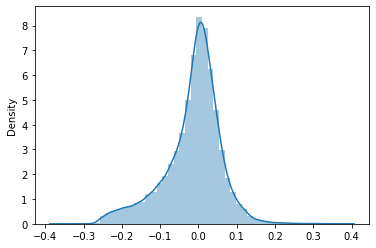

In [216]:
import seaborn as sns
sns.distplot(v)

In [205]:
vals_2, inds_2 = get_topk_cossim(val_embeddings, nonlandmark_embeddings, k=11)
# starting from index 1 on val as index 0 is the same image
vals_2 = vals_2[:,1:].mean(axis=1).detach().cpu().numpy()

100%|██████████| 276/276 [00:00<00:00, 442.07it/s]


In [193]:
# penalize by C
import scipy as sp

l3 = pd.Series(l.copy()).reset_index(drop=True)
v3 = v.copy()

v3 -= 1*vals_2

# val_score = comp_metric(out_val["targets"][:], [l3[:], v3[:]], ignore_non_landmarks=False)
# print(val_score)
# val_score = comp_metric(out_val["targets"][:], [l3[:], v3[:]], ignore_non_landmarks=True)
# print(val_score)

ValueError: operands could not be broadcast together with shapes (37964,) (17621,) (37964,) 

<AxesSubplot:ylabel='Density'>

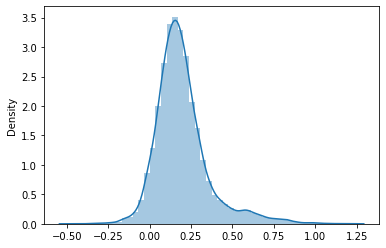

In [148]:
sns.distplot(v3)

In [80]:
from sklearn.preprocessing import normalize

# tr_embeddings = []
# val_embeddings = []
nonlandmark_embeddings = []
# targets = []
# targets_train = []

for iter, m in enumerate(models):

    set_seed(m.seed)
    
    model = Net(m)
    model = model.to(m.device)
    model.load_state_dict(torch.load(m.model))

    val_outputs = test(model, test_loader)
    nonlandmark_embeddings_x = [d['embeddings'] for d in val_outputs]
    
    nonlandmark_embeddings.append(nonlandmark_embeddings_x)

100%|██████████| 1187/1187 [03:00<00:00,  6.59it/s]


In [82]:
# np.save('../embedding_numpy/test_config1_config3.npy', nonlandmark_embeddings)

In [150]:
l3

0        114
1        114
2        114
3        114
4        114
        ... 
17616     99
17617     99
17618     99
17619     99
17620     99
Length: 17621, dtype: int64

In [151]:
v3

array([0.8300781 , 0.3544424 , 0.48954815, ..., 0.45370644, 0.53909624,
       0.5431435 ], dtype=float32)

In [59]:
sub = pd.read_csv('../data/public/sample_submission.csv')
sub['filepath'] = [os.path.join('../data/public/test', id, folder+'.JPG') for id, folder in zip(sub['id'].apply(lambda x: x[0]), sub['id'])]

In [60]:
bs = 32

test_dataset = LMDataset(sub, aug=config2.val_aug, normalization=config2.normalization, is_test=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=bs, num_workers=8, shuffle=False, pin_memory=True)

In [7]:
from tqdm import tqdm
import gc

iter = 0

model.eval()
test_outputs = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        batch['input'] = batch['input'].to(args.device)

        output_dict = model(batch, get_embeddings=True)

        logits = output_dict['logits']
        embeddings = output_dict['embeddings']

        preds_conf, preds = torch.max(logits.softmax(1),1)

        allowed_classes = torch.Tensor(list(range(args.n_classes))).long().to(logits.device)

        preds_conf_pp, preds_pp = torch.max(logits.gather(1,allowed_classes.repeat(logits.size(0),1)).softmax(1),1)
        preds_pp = allowed_classes[preds_pp]

        output = dict({
            'idx':batch['idx'].detach().cpu().numpy(),
            # 'embeddings': embeddings,
            'preds': preds.detach().cpu().numpy(),
            'preds_conf':preds_conf.detach().cpu().numpy(),
            'preds_pp': preds_pp.detach().cpu().numpy(),
            'preds_conf_pp':preds_conf_pp.detach().cpu().numpy(),
            
        })
        # test_outputs += [output]

        if (output['preds'] == output['preds_pp']).sum() == (output['preds_conf'] == output['preds_conf_pp']).sum() == bs:
            sub['landmark_id'].iloc[bs*iter:bs*(iter+1)] = output['preds_pp']
            sub['conf'].iloc[bs*iter:bs*(iter+1)] = output['preds_conf_pp']
        else:
            sub['landmark_id'].iloc[bs*iter:bs*(iter+1)] = output['preds_pp']
            sub['conf'].iloc[bs*iter:bs*(iter+1)] = output['preds_conf_pp']
            print(iter)
            
        iter+=1

100%|██████████| 1187/1187 [03:37<00:00,  5.47it/s]1186



In [9]:
sub.drop(columns=['filepath']).to_csv('../submit/baseline_3.csv', index=False)

# data move

In [17]:
import os
import pandas as pd
from glob import glob
import random
import shutil # 파일 이동에 사용
import natsort as nt # 파일 sort에 사용
import matplotlib.pyplot as plt
import numpy as np

In [21]:
path_train = os.path.join('../data/public/train')
path_cate_csv = os.path.join('../data/public/category.csv')
df_cate = pd.read_csv(path_cate_csv)
df_cate.head()

,landmark_id,landmark_name
0,0,금천구청
1,1,두리랜드
2,2,이대원 장군묘
3,3,성공회대학교
4,4,송상현공 동상


In [23]:
df_dict = dict(df_cate.values[:,::-1]) # 데이터 프레임 안의 내용 dict로 받음

In [24]:
train_list = glob(os.path.join(path_train, '*', '*', '*.JPG'))

In [26]:
def load_class_idx_from_path(img_path, category_dict): 
    # DongminChoi 님 코드 공유에서 함수 잘 만들어 놓으셔서 가져왔습니다.
    
    '''
    Load class index from data path based on class name
    '''
    filename = os.path.basename(img_path)
    class_name = ' '.join(filename.split('_')[:-1])
    
    # 이케아_광명, 이케아_고양 폴더명에 _가 포함되어 있어 따로 다시 class_name을 처리해줍니다.
    
    print(filename)
    print(class_name)
    if class_name =='이케아 광명':
        class_name ='이케아_광명'
    if class_name =='이케아 고양':
        class_name = '이케아_고양'
    return category_dict[class_name]


path_train_new = os.path.join('../data/train')


def make_folder(folder_name): # 폴더 생성 함수

    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
        
make_folder(path_train_new)


# 미리 class_id 이름으로 이동시킬 폴더를 생성합니다.

for i in range(len(df_cate)):
    path_train_class = os.path.join(path_train_new, str(i))
    
    make_folder(path_train_class)


# 기존 train에서 class_id로 만들어진 새로운 train_new 폴더로 이동(복사 아님) 시킵니다.
    
for i, image in enumerate(train_list):
    

    idx = image.rfind('/')
    image_name = image[idx:]

    class_id = load_class_idx_from_path(image, df_dict)
    path_shutil = os.path.join(path_train_new, '%d'%class_id  + image_name)

    
    shutil.move(image, path_shutil)

.JPG
낙산 묘각사
낙산_묘각사_055.JPG
낙산 묘각사
낙산_묘각사_116.JPG
낙산 묘각사
낙산_묘각사_039.JPG
낙산 묘각사
낙산_묘각사_027.JPG
낙산 묘각사
낙산_묘각사_013.JPG
낙산 묘각사
낙산_묘각사_047.JPG
낙산 묘각사
낙산_묘각사_080.JPG
낙산 묘각사
낙산_묘각사_097.JPG
낙산 묘각사
낙산_묘각사_002.JPG
낙산 묘각사
낙산_묘각사_099.JPG
낙산 묘각사
낙산_묘각사_119.JPG
낙산 묘각사
낙산_묘각사_064.JPG
낙산 묘각사
낙산_묘각사_092.JPG
낙산 묘각사
낙산_묘각사_093.JPG
낙산 묘각사
낙산_묘각사_023.JPG
낙산 묘각사
낙산_묘각사_040.JPG
낙산 묘각사
낙산_묘각사_086.JPG
낙산 묘각사
낙산_묘각사_059.JPG
낙산 묘각사
낙산_묘각사_120.JPG
낙산 묘각사
낙산_묘각사_061.JPG
낙산 묘각사
낙산_묘각사_108.JPG
낙산 묘각사
낙산_묘각사_001.JPG
낙산 묘각사
낙산_묘각사_003.JPG
낙산 묘각사
낙산_묘각사_021.JPG
낙산 묘각사
낙산_묘각사_117.JPG
낙산 묘각사
낙산_묘각사_065.JPG
낙산 묘각사
낙산_묘각사_082.JPG
낙산 묘각사
낙산_묘각사_058.JPG
낙산 묘각사
낙산_묘각사_077.JPG
낙산 묘각사
낙산_묘각사_069.JPG
낙산 묘각사
낙산_묘각사_032.JPG
낙산 묘각사
낙산_묘각사_083.JPG
낙산 묘각사
낙산_묘각사_113.JPG
낙산 묘각사
낙산_묘각사_062.JPG
낙산 묘각사
낙산_묘각사_066.JPG
낙산 묘각사
낙산_묘각사_074.JPG
낙산 묘각사
낙산_묘각사_007.JPG
낙산 묘각사
낙산_묘각사_010.JPG
낙산 묘각사
낙산_묘각사_026.JPG
낙산 묘각사
낙산_묘각사_063.JPG
낙산 묘각사
낙산_묘각사_006.JPG
낙산 묘각사
낙산_묘각사_103.JPG
낙산 묘각사
낙산_묘각사_087.JPG
낙산 묘각사
낙산_묘각사_049.JPG
낙산 묘각사
낙산_묘각사_067.JPG
낙산 묘각

In [32]:
abc = os.listdir('../data/train/')

In [33]:
len(abc)

1049

In [40]:
file_count = []
for path in os.listdir('../data/train/'):
    path = os.path.join('../data/train/', path)
    count = len(os.listdir(path))
    file_count += [count]
else:
    print(pd.Series(file_count).value_counts())

84     96
85     87
82     85
86     82
88     71
83     69
87     64
80     61
79     60
81     57
89     53
90     37
78     37
76     35
91     26
92     25
93     19
77     19
75     13
94     10
74      8
72      6
70      5
73      5
97      4
96      4
95      4
101     2
71      2
69      1
67      1
66      1
dtype: int64


In [45]:
sum(file_count)

88102